# **RAFT Base**

In this notebook we will create a new Neural Network Architecture using RAFT as a Base

This will just be to make the base architecture and test a dataloader

In [1]:
import os
import sys
import time
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append('RAFT/core')
     
from raft_utils import *

In [3]:
splits = [0.8, 0.1, 0.1]
split_indexes = []
l = 8100

idx = 0
for s in splits:
    s_idx = np.round(l*s).astype(int)
    split_indexes.append((idx, idx + s_idx))
    idx += s_idx



l*0.8, l*0.111, l*0.099

(6480.0, 899.1, 801.9000000000001)

In [30]:
split_indexes

[(0, 6480), (6480, 7290), (7290, 8100)]

In [16]:
6480 + 810 + 810

8100

In [21]:
splits = [0.8, 0.111, 0.089]
for s in splits:
    n = l*s
    print(n, n % 1)

    if ((n % 1) != 0):
        print(np.round(n%1))

        

6480.0 0.0
899.1 0.10000000000002274
0.0
720.9 0.8999999999999773
1.0


In [20]:
0.2 - 0.111

0.08900000000000001

In [22]:
6480 + 899 + 721, sum(splits)

(8100, 1.0)

In [40]:
df = pd.read_csv(r"C:\Users\itber\Documents\datasets\mars_auto\train.txt", header=None)
l = len(df)
print(len(df))

8100


In [41]:
splits = [0.8, 0.1, 0.1]
split_indexes = []

idx = 0
for s in splits:
    s_idx = np.round(l*s).astype(int)
    split_indexes.append((idx, idx + s_idx))
    idx += s_idx



In [48]:
split_indexes, l

([(0, 6480), (6480, 7290), (7290, 8100)], 8100)

In [47]:
split_indexes[0][1] - split_indexes[0][0], split_indexes[1][1] - split_indexes[1][0], split_indexes[2][1] - split_indexes[2][0]

(6480, 810, 810)

In [56]:
# df.iloc[6480:6480+810]
df.iloc[6480+810:6480+810+810].shape

(810, 1)

## **Get the Data**

In [4]:
data_path = r"C:\Users\itber\Documents\datasets\mars_auto"

In [5]:
# cap = cv2.VideoCapture(os.path.join(data_path, "train.mp4"))

# if (cap.isOpened() == False):
#     print("Error opening video file")

# X_test = []
# prev_frame = None
# i = 0
# while(cap.isOpened()):

#     # read each video frame
#     ret, frame = cap.read()

#     if ret == True:
#         cv2.imwrite(os.path.join(data_path, f"train/frame_{i}.png"), frame)

#         # increment counter
#         i += 1

#     # Break if nothing is returned
#     else:
#         break

# # clean up
# cap.release()
# cv2.destroyAllWindows()
# del cap
     


## **Build the Model**

In [6]:
raft_model = load_model("RAFT/models/raft-sintel.pth", args=Args())

for name, child in raft_model.module.named_children():
    print(name)

fnet
cnet
update_block


In [7]:
fnet = raft_model.module.fnet
cnet = raft_model.module.cnet

In [26]:
import torch.nn as nn
import torch.nn.functional as F

from RAFT.core.extractor import BottleneckBlock
from RAFT.core.corr import CorrBlock
from RAFT.core.utils.utils import coords_grid


class Network(nn.Module):
    def __init__(self, fnet, corr_radius=4, freeze_encoder=True, device='cuda'):
        super().__init__()

        self.fnet = fnet
        self.corr_radius = corr_radius
        self.device = device

        self.bottle1 = BottleneckBlock(in_planes=324, planes=64, norm_fn='batch', stride=2).to(self.device)

        self.conv1 = nn.Conv2d(in_channels=324, out_channels=64, kernel_size=3, stride=2, dilation=1, padding=0).to(self.device)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, dilation=1, padding=0).to(self.device)

        self.fc1 = nn.Linear(in_features=5376, out_features=256).to(self.device)
        self.fc2 = nn.Linear(in_features=256, out_features=1).to(self.device)

        self.norm1 = nn.BatchNorm2d(num_features=64)
        self.norm2 = nn.BatchNorm2d(num_features=16)

        self.norm = nn.BatchNorm1d(num_features=256).to(self.device)

        # freeze encoder weights
        if freeze_encoder:
            for child in self.fnet.children():
                for param in child.parameters():
                    param.requires_grad = False


    def initialize_flow(self, img):
        """ Flow is represented as difference between two coordinate grids flow = coords1 - coords0"""
        N, C, H, W = img.shape
        coords0 = coords_grid(N, H//8, W//8, device=img.device)
        coords1 = coords_grid(N, H//8, W//8, device=img.device)

        # optical flow computed as difference: flow = coords1 - coords0
        return coords0, coords1
    

    def forward(self, image1, image2):
        # prep images
        image1 = 2 * (image1 / 255.0) - 1.0
        image2 = 2 * (image2 / 255.0) - 1.0

        image1 = image1.contiguous()
        image2 = image2.contiguous()


        # run the feature network
        with torch.autocast(device_type=self.device, enabled=True):
            fmap1, fmap2 = self.fnet([image1, image2])

        fmap1 = fmap1.float()
        fmap2 = fmap2.float()

        # get correlation function (and correlation pyramid)
        corr_fn = CorrBlock(fmap1, fmap2, radius=self.corr_radius)

        # corr_fn.corr_pyramid

        _, coords1 = self.initialize_flow(image1)

        # index correlation volume to get correlation features
        corr_features = corr_fn(coords1.detach())

        # reduce to extract speed estimation
        # out = self.bottle1(corr_features)
        # out = self.conv1(out)

        out = F.relu(self.norm1(self.conv1(corr_features)))
        out = F.relu(self.norm2(self.conv2(out)))

        out = out.reshape(out.size()[0], -1)

        out = F.leaky_relu(self.norm(self.fc1(out)), 0.01)
        # out = F.leaky_relu(self.fc1(out), 0.01)
        out = self.fc2(out)

        return out.squeeze()
    
    

In [27]:
552/8, 720/8

(69.0, 90.0)

In [28]:
model = Network(fnet).to("cuda")
model.eval();

Get test images

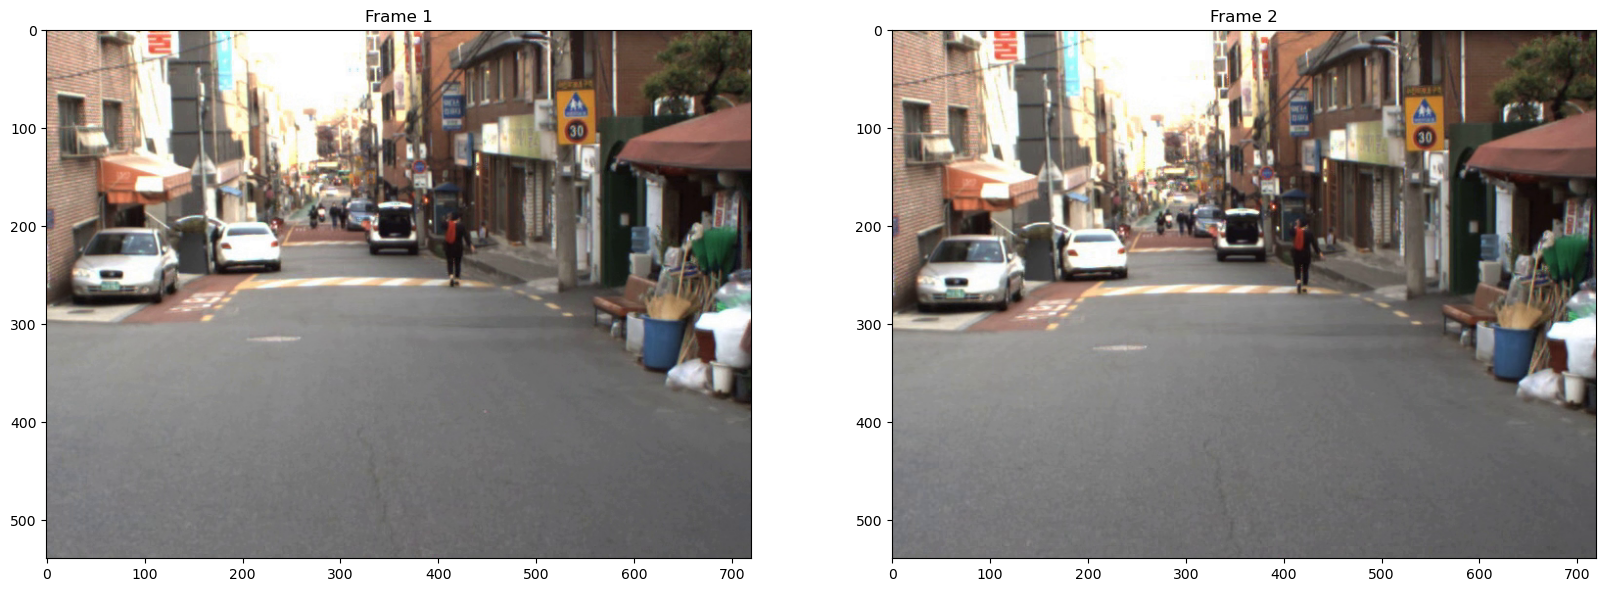

In [29]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread('data/frame_227.png')
frame2 = cv2.imread('data/frame_228.png')

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)


_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(frame1)
ax[0].set_title("Frame 1")
ax[1].imshow(frame2)
ax[1].set_title("Frame 2");

### Run network on images

In [32]:
tic = time.perf_counter()

# prepocess image
image1 = process_img(frame1, device='cuda')
image2 = process_img(frame2, device='cuda')

print(image1.shape)

# pad to ensure that it is divisible by 8
padder = InputPadder(image1.shape, mode=None)
image1, image2 = padder.pad(image1, image2)

print(image1.shape)

# forward pass through model
out = model(image1, image2)

time.perf_counter() - tic

torch.Size([1, 3, 540, 720])
torch.Size([1, 3, 544, 720])
torch.Size([1, 16, 16, 21])
torch.Size([1, 5376])


0.01707379999999148

In [ ]:
out

tensor(-0.0737, device='cuda:0', grad_fn=<SqueezeBackward0>)

## **Create the dataloader**

In [77]:
from torch.utils.data import Dataset


class MarsDataset(Dataset):
    def __init__(self, root, transform=None, train=True):
        self.root = root
        self.transform = transform
        self.train = train
        
        if self.train: 
            self.speed_df = pd.read_csv(os.path.join(self.root, "train.txt"), header=None)
            self.root = os.path.join(self.root, "train")
        else:
            self.speed_df = None
            self.root = os.path.join(self.root, "test")
   

    def __getitem__(self, idx):
        """ Obtains two seuqential image frames and their correpsonding speed.
            Assumes that the frame filenames are 0 indexed.
            """
        image1 = cv2.imread(os.path.join(self.root, f"frame_{idx}.png"))
        image2 = cv2.imread(os.path.join(self.root, f"frame_{idx + 1}.png"))

        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

        if self.train:
            speed = self.speed_df.iloc[idx + 1][0]
        else:
            speed = None

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return (image1, image2), speed


    def __len__(self):
        """ Returns total length minus 1 to account for 
            the fact that two images are needed and we
            don't use the very first speed value.
            """
        return len(self.speed_df) - 1
    
    
    
def viz(_frame, y_true, y_pred):
    """ Draws true and predicted speeds on a frame """
    # make copy of frame so we don't overwrite it
    frame = _frame.copy()
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX

    # org
    org_true = (15, 30)
    org_pred = (15, 65)

    # fontScale
    fontScale = 1

    # Blue color in BGR
    color_true = (5, 255, 5)
    color_pred = (255, 255, 255)

    # Line thickness of 2 px
    thickness = 3

    # draw speeds on frame
    frame = cv2.putText(frame, f"True Speed: {y_true:.3f}", org_true, font,
                fontScale, (0,0,0), 15, cv2.LINE_AA)
    frame = cv2.putText(frame, f"True Speed: {y_true:.3f}", org_true, font,
                        fontScale, color_true, thickness, cv2.LINE_AA)

    frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                        fontScale, (0,0,0), 15, cv2.LINE_AA)
    frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                        fontScale, color_pred, thickness, cv2.LINE_AA)
    
    return frame



In [78]:
dataset = MarsDataset(data_path, transform=None, train=True)

In [79]:
(image1, image2), speed = dataset[300]

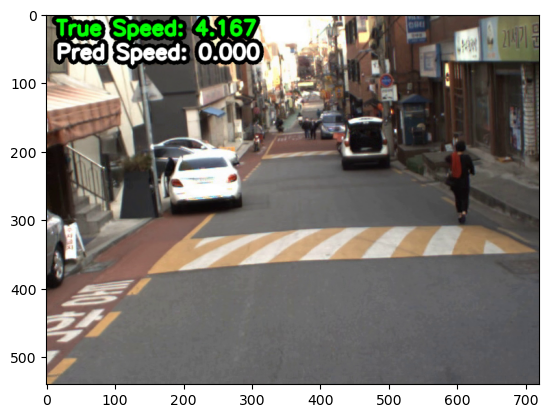

In [80]:
plt.imshow(viz(image2, speed, 0))

Test dataset splits

In [69]:
len(dataset)

8100

In [72]:
train_len = int(len(dataset) * 0.8)
valid_len = int(len(dataset) * 0.1)
test_len = int(len(dataset) * 0.1)

train_len, valid_len, test_len

(6480, 810, 810)

In [75]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_len, valid_len, test_len))

In [76]:
len(valid_dataset)

810